## Imports

In [1]:
# Pytorch stuff
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms

# Utilities
import time
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
from sklearn.metrics import confusion_matrix, f1_score

## Settings and Dataset

In [2]:
##########################
### SETTINGS
##########################

# Hyperparameters - recommended from pytorch implementation of RESNET18
learning_rate = 0.01
num_epochs = 10
batch_size = 128

# Architecture
num_classes = 10


##########################
### MNIST DATASET
##########################

# Note transforms.ToTensor() scales input images
# to 0-1 range
train_dataset = datasets.MNIST(root='data', 
                               train=True, 
                               transform=transforms.ToTensor(),
                               download=True)

test_dataset = datasets.MNIST(root='data', 
                              train=False, 
                              transform=transforms.ToTensor())

# DataLoader providing iterable batches of dataset

train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=batch_size, 
                          shuffle=True)

test_loader = DataLoader(dataset=test_dataset, 
                         batch_size=batch_size, 
                         shuffle=False)

# Checking the dataset
for images, labels in train_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

Image batch dimensions: torch.Size([128, 1, 28, 28])
Image label dimensions: torch.Size([128])


## ResNet with identity blocks

In [3]:
##########################
### MODEL
##########################

class ConvNet(torch.nn.Module):

    def __init__(self, num_classes):
        super(ConvNet, self).__init__()
        
        #########################
        ### 1st residual block
        #########################
        # 28x28x1 => 28x28x4
        self.conv_1 = torch.nn.Conv2d(in_channels=1,
                                      out_channels=4,
                                      kernel_size=(1, 1),
                                      stride=(1, 1),
                                      padding=0)
        self.conv_1_bn = torch.nn.BatchNorm2d(4)
                                    
        # 28x28x4 => 28x28x1
        self.conv_2 = torch.nn.Conv2d(in_channels=4,
                                      out_channels=1,
                                      kernel_size=(3, 3),
                                      stride=(1, 1),
                                      padding=1)   
        self.conv_2_bn = torch.nn.BatchNorm2d(1)
        
        
        #########################
        ### 2nd residual block
        #########################
        # 28x28x1 => 28x28x4
        self.conv_3 = torch.nn.Conv2d(in_channels=1,
                                      out_channels=4,
                                      kernel_size=(1, 1),
                                      stride=(1, 1),
                                      padding=0)
        self.conv_3_bn = torch.nn.BatchNorm2d(4)
      
        # 28x28x4 => 28x28x1
        self.conv_4 = torch.nn.Conv2d(in_channels=4,
                                      out_channels=1,
                                      kernel_size=(3, 3),
                                      stride=(1, 1),
                                      padding=1)   
        self.conv_4_bn = torch.nn.BatchNorm2d(1)

        #########################
        ### Fully connected
        #########################        
        self.linear_1 = torch.nn.Linear(28*28*1, num_classes)

    # FORWARD PASS METHOD IMPLEMENTED AS RESNET
    
    def forward(self, x):
        
        #########################
        ### 1st residual block
        #########################
        
        out = self.conv_1(x)
        out = self.conv_1_bn(out)
        out = F.relu(out)

        out = self.conv_2(out)
        out = self.conv_2_bn(out)
        
        out = F.relu(out)
        
        #########################
        ### 2nd residual block
        #########################
        
        out = self.conv_3(out)
        out = self.conv_3_bn(out)
        out = F.relu(out)

        out = self.conv_4(out)
        out = self.conv_4_bn(out)
        
        out = F.relu(out)
        
        #########################
        ### Fully connected
        #########################   
        logits = self.linear_1(out.view(-1, 28*28*1))
        probas = F.softmax(logits, dim=1)
        return logits, probas
    
model = ConvNet(num_classes=num_classes)

# Optimizer chosen by implementation is the Adam algorithm. Standard Gradient Descent can also be implemented.
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  

### Training

In [5]:
def compute_accuracy(model, data_loader):
    correct_pred, num_examples = 0, 0

    for i, (features, targets) in enumerate(data_loader):            
        logits, probas = model(features)
        _, predicted_labels = torch.max(probas, 1)
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()

    return correct_pred.float()/num_examples * 100

start_time = time.time()

for epoch in range(num_epochs):
    model = model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):
        
        ### FORWARD AND BACK PROP
        logits, probas = model(features)
        cost = F.cross_entropy(logits, targets)
        optimizer.zero_grad()
        
        cost.backward()
        
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        ### LOGGING
        if not batch_idx % 50:
            print ('Epoch: %03d/%03d | Batch %03d/%03d | Cost: %.4f' 
                   %(epoch+1, num_epochs, batch_idx, 
                     len(train_loader), cost))

    # USE ONLY TO PRINT ACC FOR EACH EPOCH - WASTES TIME

    model = model.eval() # eval mode to prevent upd. batchnorm params during inference
    with torch.set_grad_enabled(False): # save memory during inference
        print('Epoch: %03d/%03d training accuracy: %.2f%%' % (
              epoch+1, num_epochs, 
              compute_accuracy(model, train_loader)))

    print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))
    
print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

Epoch: 001/010 | Batch 000/469 | Cost: 0.1842
Epoch: 001/010 | Batch 050/469 | Cost: 0.2363
Epoch: 001/010 | Batch 100/469 | Cost: 0.2941
Epoch: 001/010 | Batch 150/469 | Cost: 0.2434
Epoch: 001/010 | Batch 200/469 | Cost: 0.1322
Epoch: 001/010 | Batch 250/469 | Cost: 0.2366
Epoch: 001/010 | Batch 300/469 | Cost: 0.2476
Epoch: 001/010 | Batch 350/469 | Cost: 0.3057
Epoch: 001/010 | Batch 400/469 | Cost: 0.1401
Epoch: 001/010 | Batch 450/469 | Cost: 0.2155
Epoch: 001/010 training accuracy: 92.80%
Time elapsed: 0.69 min
Epoch: 002/010 | Batch 000/469 | Cost: 0.2331
Epoch: 002/010 | Batch 050/469 | Cost: 0.1739
Epoch: 002/010 | Batch 100/469 | Cost: 0.1974
Epoch: 002/010 | Batch 150/469 | Cost: 0.3417
Epoch: 002/010 | Batch 200/469 | Cost: 0.3170
Epoch: 002/010 | Batch 250/469 | Cost: 0.2021
Epoch: 002/010 | Batch 300/469 | Cost: 0.1856
Epoch: 002/010 | Batch 350/469 | Cost: 0.1816
Epoch: 002/010 | Batch 400/469 | Cost: 0.3257
Epoch: 002/010 | Batch 450/469 | Cost: 0.3216
Epoch: 002/010 t

### Prediction Function

In [6]:
def inference(input_image):
    preprocess = transforms.Compose([
        transforms.Resize((28,28)), # transforms any digit image to 28x28 and grayscale image, inverted black and white
        transforms.Grayscale(),
        transforms.RandomInvert(1),
        transforms.ToTensor()
    ])
    input_tensor = preprocess(input_image)
    input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

    output = model(input_batch)
    
    probabilities = output[1][0] # Select probs and reduce dimension

    print(probabilities.tolist())
    
    categories = [0,1,2,3,4,5,6,7,8,9]
    prob, catid = torch.topk(probabilities, 1)
    result = {"label":categories[catid],"probability":prob.tolist()[0]}

    return result

### Using prediction function with a local image

In [7]:
image = Image.open("data/images/5.png")

print(inference(image))

# Transformation is already done withing the inference function
# This is just for displaying the input image

resize_transform = transforms.Compose([
        transforms.Resize((28,28)),
        transforms.Grayscale(),
        transforms.RandomInvert(1)
    ])

# Apply the transform to the image
resize_transform(image)

[3.9844075217843056e-05, 8.244468290286022e-07, 0.009784547612071037, 0.011447097174823284, 4.736883784062229e-05, 0.8011446595191956, 0.0007414614083245397, 5.625354901894752e-07, 0.17595544457435608, 0.0008381863008253276]
{'label': 5, 'probability': 0.8011446595191956}


### Using prediction function with an image from data set

Shape of the sample image: torch.Size([1, 28, 28])
Label of the sample image: 6


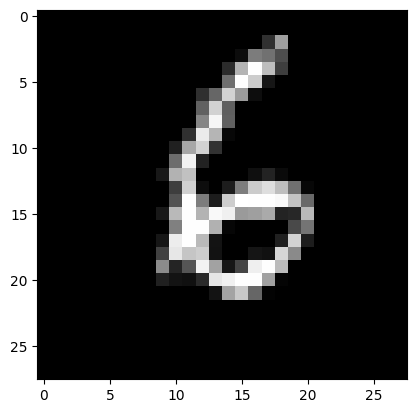

[4.2149091510216094e-20, 6.965954510186138e-21, 0.9999938011169434, 2.2373255862979252e-13, 1.0519941691818739e-22, 6.242389190447284e-06, 2.504751233177614e-19, 7.316040286755881e-20, 1.350664643063465e-13, 1.3505927968572373e-20]


{'label': 2, 'probability': 0.9999938011169434}

In [84]:
sample_image, sample_label = test_dataset[2000]

# Print the shape of the sample image
print("Shape of the sample image:", sample_image.shape)

# Print the label of the sample image
print("Label of the sample image:", sample_label)

plt.imshow(sample_image[0], cmap='gray')
plt.show()

to_pil_img = transforms.ToPILImage()
img = to_pil_img(sample_image)
inference(img)

### Accuracy, Confusion Matrix, F score

tensor(94.4933) 0.9443445423214236


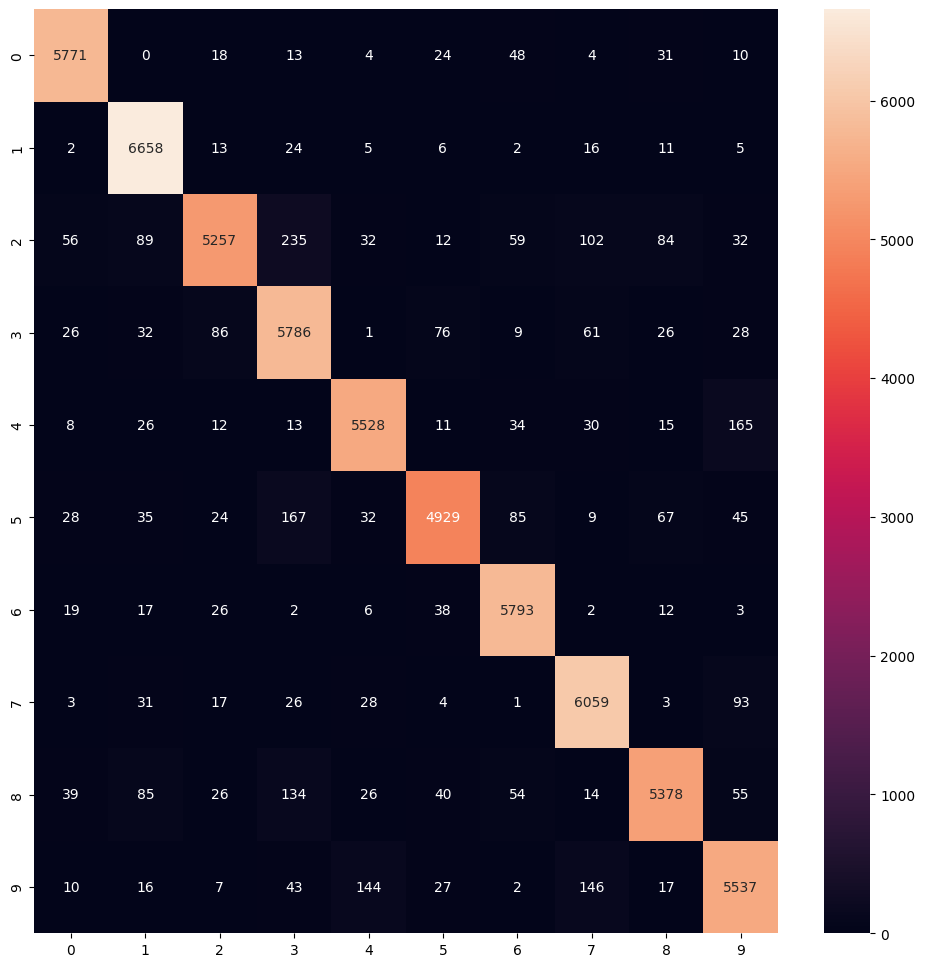

In [8]:
def compute_accuracy_and_cm(model, data_loader):
    correct_pred, num_examples = 0, 0
    true_labels, pred_labels = [], []
    for i, (features, targets) in enumerate(data_loader):            
        logits, probas = model(features)
        _, predicted_labels = torch.max(probas, 1)
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()
        true_labels.append(targets)
        pred_labels.append(predicted_labels)
    true_labels = np.concatenate(true_labels)
    pred_labels = np.concatenate(pred_labels)
    cm = confusion_matrix(true_labels, pred_labels)
    f1 = f1_score(true_labels, pred_labels, average='macro')
    return correct_pred, num_examples, correct_pred.float()/num_examples * 100, cm, f1

a,b,accuracy,cm, f1 = compute_accuracy_and_cm(model,train_loader)

print(accuracy,f1)
class_types = [0,1,2,3,4,5,6,7,8,9]

plt.figure(figsize=(12,12))
sns_hmp = sns.heatmap(cm, annot=True, xticklabels = class_types, 
            yticklabels = class_types, fmt="d")
fig = sns_hmp.get_figure()